## <p style="text-align: center;">B9AI103_2122_TMD3_CA_1</p>
### <p style="text-align: center;"> Details </p>
#### <p style="text-align: center;">Name: Sunil Judhistira Gauda</p>
#### <p style="text-align: center;">Student ID : 10595858 </p>

## Hybrid Movie Recommendation using Movie Lense Large Data set

Note : 
* Running cosine similarity might take some computaion and time

### Imports
1. numpy, pandas - for numeric computation and data management
2. scikit learn - for TFIDF Vectorising and cosine similarity
3. surprise - scikit learn extension to work on rating based data
    * surprise may or may not install directly depending on OS, below is the direct way of downloading and installing scikit-surprise
    * Installation Instructions
        * pip install numpy cython
        * git clone https://github.com/NicolasHug/surprise.git
        * cd surprise
        * python setup.py install
4. wordcloud - represent word density
5. itertools - create a combination to work with

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader, Dataset, SVD
from surprise.model_selection import KFold
from surprise.model_selection.validation import cross_validate
import matplotlib.pyplot as plt
from  wordcloud import WordCloud
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity


### Importing the data
* Data we require are as follows
    * Meta-Data like **Genre** for **content based** filtering
    * User Data like **Ratings** for **collaberative** filtering
* **Hybrid** recommendation will be the combination of **content and collaberative** filtering

Note : 
Use the following link for smaller data set as the large dataset can fail on calculateing cosine simliarity with less memory
* https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
* **update the path of the data**
* **use_large** should be **False**

In [2]:
use_large = True
if use_large:
    movies = pd.read_csv("../../../../DataSets/ml-latest/movies.csv")
    ratings = pd.read_csv("../../../../DataSets/ml-latest/ratings.csv")
    tags = pd.read_csv("../../../../DataSets/ml-latest/tags.csv")
    links = pd.read_csv("../../../../DataSets/ml-latest/links.csv")
else :
    movies = pd.read_csv("../../../../DataSets/ml-latest-small/movies.csv")
    ratings = pd.read_csv("../../../../DataSets/ml-latest-small/ratings.csv")
    tags = pd.read_csv("../../../../DataSets/ml-latest-small/tags.csv")
    links = pd.read_csv("../../../../DataSets/ml-latest-small/links.csv")

### Exploratory Analysis of the Data
Steps inncluded for Data Analysis includes
* Data Preparation
* Data Exploration
* Data Visualisation

#### Data Preparation

##### Seperating **Year** from the **Titile** of the movie
* As the data we have merged the title of the movie with the date it was released we dont have any seperate data for year of release
* Using few techniques below we will seperate date from the title and convert date into int and title into string

In [3]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*',expand = False)
movies['year'] = movies['year'].str.extract('(\d+)', expand=False)
movies.dropna(inplace=True)
movies['year'] = movies['year'].astype(int)
movies['title'] = movies['title'].replace(r'\([^)]*\)', '', regex=True).str.lower()
movies['title'] = movies['title'].str.rstrip()
movies['title'] = movies['title'].str.lstrip()
movies['title'] = movies['title'].astype("string")
movies.head()

,movieId,title,genres,year
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,jumanji,Adventure|Children|Fantasy,1995
2,3,grumpier old men,Comedy|Romance,1995
3,4,waiting to exhale,Comedy|Drama|Romance,1995
4,5,father of the bride part ii,Comedy,1995


##### Preparing the final DataFrame
Final Data Frame contains all the data required for exploratory analysis of the data and visualise the data using various techniques.

In [4]:
# Preparing the Data frame by combining all necessary columns from other dataframes
final_df = movies
final_df["userid"] = ratings["userId"]
final_df["rating"] = ratings["rating"]
final_df["timestamp"] = ratings["timestamp"]
final_df["tag"] = tags["tag"]
final_df["tmdbId"] = links["tmdbId"]


##### Dropping the NA columns
As we have a huge amount of data, and the NA counts for tags only, that is also few hundread of the entire dataset we can get rid of NA rows.

In [5]:
final_df.dropna(inplace=True)
final_df.isna().sum()

movieId      0
title        0
genres       0
year         0
userid       0
rating       0
timestamp    0
tag          0
tmdbId       0
dtype: int64

#### Data Exploration

**Sample of our final data set**

In [6]:
final_df.head()

,movieId,title,genres,year,userid,rating,timestamp,tag,tmdbId
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,3.5,1256677221,epic,862.0
1,2,jumanji,Adventure|Children|Fantasy,1995,1,3.5,1256677456,Medieval,8844.0
2,3,grumpier old men,Comedy|Romance,1995,1,1.5,1256677471,sci-fi,15602.0
3,4,waiting to exhale,Comedy|Drama|Romance,1995,1,4.5,1256677460,space action,31357.0
4,5,father of the bride part ii,Comedy,1995,1,4.5,1256677264,imdb top 250,11862.0


**Shape of the Data**

In [7]:
final_df.shape

(57595, 9)

**Data Description**

In [8]:
final_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57595 entries, 0 to 58097
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movieId    57595 non-null  int64  
 1   title      57595 non-null  string 
 2   genres     57595 non-null  object 
 3   year       57595 non-null  int32  
 4   userid     57595 non-null  int64  
 5   rating     57595 non-null  float64
 6   timestamp  57595 non-null  int64  
 7   tag        57595 non-null  object 
 8   tmdbId     57595 non-null  float64
dtypes: float64(2), int32(1), int64(3), object(2), string(1)
memory usage: 4.2+ MB


##### Listing the top 10 rated movies

In [9]:
final_df[['title', 'rating']].sort_values('rating', ascending=False).head(10)

,title,rating
28985,il medico... la studentessa,5.0
9131,drifting clouds,5.0
9133,"pretty village, pretty flame",5.0
19058,"cartoonist: jeff smith, bone and the changing ...",5.0
9137,pusher,5.0
9138,robinson crusoe,5.0
19056,twelve,5.0
28813,le grand jeu,5.0
44706,after the apocalypse,5.0
9154,kiss or kill,5.0


#### Data Visualization

##### Movies released per year
By plotting movies angainst the year of release we can clearly see that by the year 1980 - 2000 the release was at peak, i.e maximum movies were released that year as per our data set.

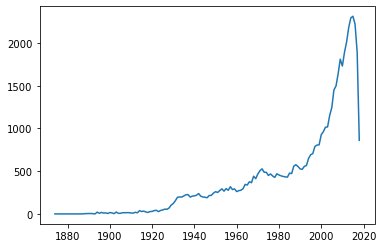

Max No.of Movies Relesed = 2312
year = 2015


count     134.000000
mean      429.813433
std       545.019130
min         1.000000
25%        29.250000
50%       261.500000
75%       501.500000
max      2312.000000
Name: title, dtype: float64

In [10]:
plt.plot(final_df.groupby('year').title.count())
plt.show()
a = final_df.groupby('year').title.count()
print('Max No.of Movies Relesed =', a.max())
for i in a.index:
    if a[i] == a.max():
        print('year =', i)
a.describe()


##### Exploring Genre's

In [11]:
genre_popularity = (final_df.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)


Drama                 24052
Comedy                15890
Thriller               8192
Romance                7392
Action                 7104
Horror                 5536
Crime                  5091
Documentary            5012
Adventure              4054
(no genres listed)     4054
Name: genres, dtype: int64

**Drama**, **Romance**, **Comedy** are the most focused genre

(-0.5, 999.5, 399.5, -0.5)

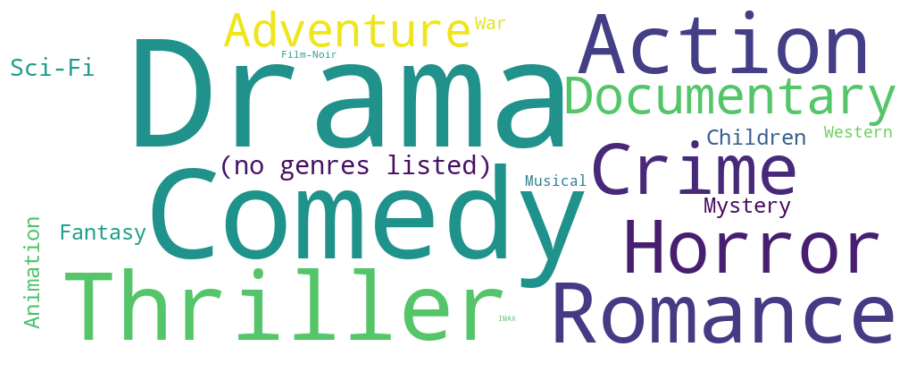

In [12]:
genre_wc = WordCloud(width=1000,height=400,background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())
plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

#### Content Based Filtering
There are two types of filtering in content based movie recommendation
1. Description Based - Based on textual description of the movie or the taglines/punchlines
2. **Meta data based** - Genre, Keywords etc <br />
    * **As we only have metadata of the movies, we will work with Meta Data based filtering**

##### TFIDF

1. Using TFIDF Vetorising we will check the frequency of **genre** in our data
2. Appling TFIDF we get a matrix representaion of the frequency of the keywords


In [13]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                     for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape


(57595, 910)

**Cosine Similarity**
Using Cosine Similarity we can find the closeness between the movie genre, as we dont need to consider the size of the data to estimate the genre, genre is independent of meaning depending on where its placed in our data, genre in any movie assignes same meaning to the data.

In [14]:
cosine_sim = cosine_similarity(tfidf_matrix)

##### Creating an Index of the movies by title to help us get the list of data while predicting.

In [15]:
indices = pd.Series(final_df.index, index=final_df['title']).drop_duplicates()

In [16]:
final_df.head()
indices


title
toy story                               0
jumanji                                 1
grumpier old men                        2
waiting to exhale                       3
father of the bride part ii             4
                                    ...  
the great glinka                    58093
les tribulations d'une caissière    58094
her name was mumu                   58095
flora                               58096
leal                                58097
Length: 57595, dtype: int64

#### Recommend using Content Based Filtering by Meta Data
To recommend based on Meta Data / Content of the movie we require the following.
* Title - Title is the key of **Index** we have created to fetch data.
* Cosine Similarity - It will help us get the titles that are close to the genre of the Movie title we provide

In [17]:
# Recommend Method
def recommend(title, cosine_sim=cosine_sim) :
    # Get the movie we out of index using the title provided
    idx = indices[title]

    # Find Movies with similar index to the title provided
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the data as per the similarty of the title
    sim_scores = sorted(sim_scores, key = lambda x:x[1], reverse = True)

    # Fetch the Top 15 of the Data which has similar score
    sim_scores = sim_scores[1:16]

    # Create the list of indexs after removing duplicates to sort movie data
    movie_indices = [i[0] for i in sim_scores]

    # Removing outliers or movies with lower rating
    for i in movie_indices:
        pop = final_df.at[i, 'rating']
        if pop<5 or pop>10:
            movie_indices.remove(i)

    return final_df[["title", "rating"]].iloc[movie_indices]

##### Checking the Content based recommendation function

In [18]:

recommend('toy story')


,title,rating
3028,toy story 2,3.5
3664,"adventures of rocky and bullwinkle, the",3.0
4791,"monsters, inc.",2.5
11009,"wild, the",4.0
13378,"tale of despereaux, the",4.0
21576,turbo,4.0
24657,aladdin,2.0
25071,toy story toons: hawaiian vacation,3.0


#### Collaberative Filtering
1. Content Based Filtering is limited by recommendations based on types of genre that are close to each other, it does not consider any aspects of user prefrence and customised user recommendation
2. Collaberative filtering we use user specific data and SVD to minimise RMSE and provide recommendations to what a user is personally interested in.

**Tools Used**
For implemneting collaberative filtering over our data, we use scikit-surprise that is a library built upon scikit learn and provides great tools like Reader, SVD to compute and manage the data.

In [19]:
# Reader is used to parse rating based data
reader = Reader()

# Using Reader to parse user specific Rating based data
u_df = Dataset.load_from_df(ratings[['userId', 'rating', 'movieId']], reader)

# Generalising data using Kfold
kf = KFold(n_splits=5)
kf.split(u_df)

<generator object KFold.split at 0x0000019C046055B0>

##### Using SVD - Single Value Decomposition to Reduce the RMSE over the data that has beed Generalised using KFlod and fitting the training set to it.

In [20]:
# SVD Object
svd = SVD()
# Crossvalidating against our dataset for RMSE reduction
cross_validate(svd, u_df, measures=['RMSE', 'MAE'])
# Fetching the training set
trainset = u_df.build_full_trainset()

# Fitting the Traing set to SVD
svd.fit(trainset)


##### Preparing Movie Data to be used for estimating movies using Hybrid Method of estimation

In [21]:
col = np.array(links['tmdbId'], np.int64)
links['tmdbId'] = col

# Merge movies_metadata.csv and links_small.csv files
links = links.merge(
    final_df[['title', 'tmdbId']], on='tmdbId').set_index('title')
links_index = links.set_index('tmdbId')


##### Hybrid Recommendation Function
1. Content Based
    * The function below uses cosine similarity to fetch the closeness by genre
    * Sorts the data as per cosine similarity scores
    * Fetching the top 30 of the data
    * Creates a list of **Movie Indexes** using the Cosine Similarity Score
2. Collaberative Filtering
    * Using our Movies Data frame to fetch necessary columns, with the **Movie Indexes** data.
    * Estimating Movies as per the list of moves by collaberative filtering with SVD Predict Function, by using the Content Based List.
    * Returing the top 15 estimated data

In [22]:
# Hybrid recommendation Function
def hybrid(userId, title):
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]  # Scores of the 30 most similar movies
    movie_indices = [i[0] for i in sim_scores]

    movies = final_df.iloc[movie_indices][['title','rating','tmdbId']]
    movies['est'] = movies['tmdbId'].apply(lambda x: svd.predict(
        userId, links_index.loc[x]['movieId']).est)  # Estimated prediction using svd
    # Rank movies according to the predicted values
    movies = movies.sort_values('est', ascending=False)
    movies.columns = ['Title' , 'Rating',
                      'TMDb Id', 'Estimated Prediction']
    return movies.head(15)  # Display top 15 similar movies


In [23]:
hybrid(1, 'jumanji')


,Title,Rating,TMDb Id,Estimated Prediction
59,"indian in the cupboard, the",1.0,11359.0,5
124,"neverending story iii, the",4.0,27793.0,5
26318,seventh son,4.0,68737.0,5
23352,trouble at timpetill,2.0,21788.0,5
22348,beings,5.0,53318.0,5
22170,back to the secret garden,3.5,29941.0,5
21667,percy jackson: sea of monsters,4.0,76285.0,5
20822,"borrowers, the",3.0,80709.0,5
17496,pelicanman,3.0,55502.0,5
16531,"polar bear king, the",3.0,37866.0,5
